In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
kB = 1.38064852e-23 # J/K
ramp_time = 5.0e-9 #s (the ramping time for extraction voltage)
f = 1.5e9 # Electrode frequency, in Hertz

## Reading E-field data

In [2]:
# loading RF E field data
data_RF = np.loadtxt("../etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)

In [3]:
data_DC0 = np.loadtxt("3D_no_ext_voltage_radial_plane_fix_all_multipoles_except_constant.fld", skiprows=2)

In [4]:
data_DC1 = np.loadtxt("grid_with_ext_voltage_200V_half.fld", skiprows=2)

In [5]:
# manipulating E field data
df_DC0 = pd.DataFrame(data_DC0, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
# dealing with the discrepency between axis notations used by this simulation and Maxwell
df_DC0 = df_DC0[["x", "z", "y", "Ex", "Ez", "Ey"]]
df_DC0.columns = ["x", "y", "z", "Ex", "Ey", "Ez"]

In [12]:
x_max_DC0, x_min_DC0 = df_DC0.x.max(), df_DC0.x.min()
y_max_DC0, y_min_DC0 = df_DC0.y.max(), df_DC0.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC0, Ny_DC0 = df_DC0.x.nunique() - 1, df_DC0.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC0, dy_DC0 = (x_max_DC0-x_min_DC0)/Nx_DC0, (y_max_DC0-y_min_DC0)/Ny_DC0 # interval size
print("x_max = ", x_max_DC0*1.0e3, "mm")
print("y_max = ", y_max_DC0*1.0e3, "mm")
print("x_min = ", x_min_DC0*1.0e3, "mm")
print("y_min = ", y_min_DC0*1.0e3, "mm")
print("spatial resolution x: ", dx_DC0*1.0e6, "um")
print("spatial resolution y: ", dy_DC0*1.0e6, "um")
print("----------")
# manipulating E field data
df_DC1 = pd.DataFrame(data_DC1, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_DC1, x_min_DC1 = df_DC1.x.max(), df_DC1.x.min()
y_max_DC1, y_min_DC1 = df_DC1.y.max(), df_DC1.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC1, Ny_DC1 = df_DC1.x.nunique() - 1, df_DC1.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC1, dy_DC1 = (x_max_DC1-x_min_DC1)/Nx_DC1, (y_max_DC1-y_min_DC1)/Ny_DC1 # interval size
print("x_max = ", x_max_DC1*1.0e3, "mm")
print("y_max = ", y_max_DC1*1.0e3, "mm")
print("x_min = ", x_min_DC1*1.0e3, "mm")
print("y_min = ", y_min_DC1*1.0e3, "mm")
print("spatial resolution x: ", dx_DC1*1.0e6, "um")
print("spatial resolution y: ", dy_DC1*1.0e6, "um")

x_max =  2.0 mm
y_max =  2.0 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  1.0 um
spatial resolution y:  1.0 um
----------
x_max =  2.0 mm
y_max =  2.0 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  1.0 um
spatial resolution y:  1.0 um


In [13]:
# manipulating E field data
df_RF = pd.DataFrame(data_RF, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_RF, x_min_RF = df_RF.x.max(), df_RF.x.min()
y_max_RF, y_min_RF = df_RF.y.max(), df_RF.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_RF, Ny_RF = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_RF, dy_RF = (x_max_RF-x_min_RF)/Nx_RF, (y_max_RF-y_min_RF)/Ny_RF # interval size
print("x_max = ", x_max_RF*1.0e3, "mm")
print("y_max = ", y_max_RF*1.0e3, "mm")
print("x_min = ", x_min_RF*1.0e3, "mm")
print("y_min = ", y_min_RF*1.0e3, "mm")
print("spatial resolution x: ", dx_RF*1.0e6, "um")
print("spatial resolution y: ", dy_RF*1.0e6, "um")

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


## Initializing DC and RF Trap Objects

In [14]:
trap_RF = quarter_trap(df_RF, x_max_RF, x_min_RF, y_max_RF, y_min_RF,\
                      Nx_RF, Ny_RF, dx_RF, dy_RF, f=f)
trap_DC0 = half_trap(df_DC0, x_max_DC0, x_min_DC0, y_max_DC0, y_min_DC0,\
                      Nx_DC0, Ny_DC0, dx_DC0, dy_DC0, f=0.0)
trap_DC1 = half_trap(df_DC1, x_max_DC1, x_min_DC1, y_max_DC1, y_min_DC1,\
                      Nx_DC1, Ny_DC1, dx_DC1, dy_DC1, f=0.0)

## Defining simulation functions (RF + a time weighted linear combination of DC voltages )

In [197]:
def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0] 
    if time < 5.0e-9:
        g1 = trap_RF.acceleration(x, y, time) + (1 - time/5.0e-9) * trap_DC0.acceleration(x, y, time) +\
        time/5.0e-9 * trap_DC1.acceleration(x, y ,time)
    else:
        g1 = trap_RF.acceleration(x, y, time) + trap_DC1.acceleration(x, y, time)
    return np.array([g0, g1])

def extracted(rho, phi, v, theta, dt, t_max):
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if trap_DC0.hit_electrodes(x, y):
            break
        if y > trap_DC0.y_max:
            extracted = True
            break
        if not trap_DC0.within_boundary(x, y):
            break
        state = trap_DC0.rk4(state, t, dt, E_field_sim)
        t += dt
    return extracted

def plot_traj(rho, phi, T, theta, dt, t_max):
    v = np.sqrt(2*kB*T/m) #speed
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    x_traj = []
    y_traj = []
    t_s = []
    trapped = True

    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not trap_RF.within_boundary(x, y):
            print("out of bound")
            trapped = False
            break
        x_traj.append(x)
        y_traj.append(y)
        t_s.append(t)
        state = trap_RF.rk4(state, t, dt, E_field_sim)
        t += dt
    x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

    print("Time step for simulation: ", dt*1.0e9, "ns")
    print("Simulation time duration: ", round(t*1.0e6, 3), "us")
    end = time.time()
    print("time:", end-start)

    plt.figure()
    plt.plot(t_s*1.0e6, x_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("x (um)")

    plt.figure()
    plt.plot(t_s*1.0e6, y_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("y (um)")

    plt.figure()
    plt.plot(x_traj*1.0e6, y_traj*1.0e6)
    plt.xlabel("x (um)")
    plt.ylabel("y (um)")
    electrode = df_DC1.loc[(np.abs(df_DC1["Ex"]) < 1.0e-8) & (np.abs(df_DC1["Ey"]) < 1.0e-8)]
    x_electrode = electrode.iloc[:, 0].values
    y_electrode = electrode.iloc[:, 1].values
    plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, "r.")
    plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, "r.")


Simulating T =  300.0 kelvin
The result for T =  300.0 kelvin:


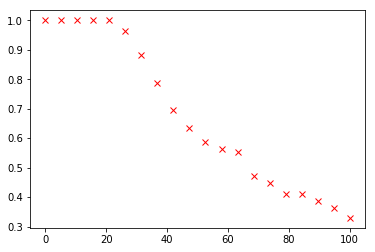

In [198]:
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

#initial condition
rho_s = np.linspace(0, 100.0e-6, 20)
N_phi = 5
N_theta = 17

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rho in rho_s
success_rate = dict() 
errors = dict()
for T in [300.0]:
    v = np.sqrt(kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rho in rho_s:
        result = []
        for phi in np.linspace(0, np.pi/2, N_phi):
            for theta in np.linspace(0, np.pi*2, N_theta):
                if extracted(rho, phi, v, theta, dt, t_max):
                    result.append(1)
                else:
                    result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_phi*N_theta))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rho_s*1.0e6, success_rate[T], 'rx')
    

Text(0.5,1,'Room Temperature')

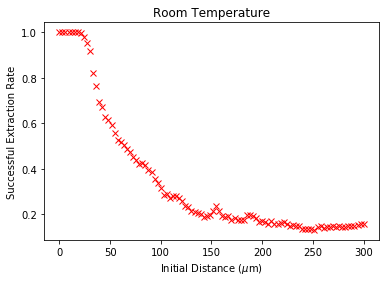

In [174]:
plt.plot(rho_s*1.0e6, success_rate[T], 'rx')
plt.xlabel("Initial Distance ($\mu$m)")
plt.ylabel("Successful Extraction Rate")
plt.title("Room Temperature")

## Trying a different ramping rate 20ns

In [186]:
def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0] 
    if time < 20.0e-9:
        g1 = trap_RF.acceleration(x, y, time) + (1 - time/20.0e-9) * trap_DC0.acceleration(x, y, time) +\
        time/20.0e-9 * trap_DC1.acceleration(x, y ,time)
    else:
        g1 = trap_RF.acceleration(x, y, time) + trap_DC1.acceleration(x, y, time)
    return np.array([g0, g1])

def extracted(rho, phi, v, theta, dt, t_max):
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if trap_DC0.hit_electrodes(x, y):
            break
        if y > trap_DC0.y_max:
            extracted = True
            break
        if not trap_DC0.within_boundary(x, y):
            break
        state = trap_DC0.rk4(state, t, dt, E_field_sim)
        t += dt
    return extracted

def plot_traj(rho, phi, T, theta, dt, t_max):
    v = np.sqrt(2*kB*T/m) #speed
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    x_traj = []
    y_traj = []
    t_s = []
    trapped = True

    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not trap_RF.within_boundary(x, y):
            print("out of bound")
            trapped = False
            break
        x_traj.append(x)
        y_traj.append(y)
        t_s.append(t)
        state = trap_RF.rk4(state, t, dt, E_field_sim)
        t += dt
    x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

    print("Time step for simulation: ", dt*1.0e9, "ns")
    print("Simulation time duration: ", round(t*1.0e6, 3), "us")
    end = time.time()
    print("time:", end-start)

    plt.figure()
    plt.plot(t_s*1.0e6, x_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("x (um)")

    plt.figure()
    plt.plot(t_s*1.0e6, y_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("y (um)")

    plt.figure()
    plt.plot(x_traj*1.0e6, y_traj*1.0e6)
    plt.xlabel("x (um)")
    plt.ylabel("y (um)")
    electrode = df_DC1.loc[(np.abs(df_DC1["Ex"]) < 1.0e-8) & (np.abs(df_DC1["Ey"]) < 1.0e-8)]
    x_electrode = electrode.iloc[:, 0].values
    y_electrode = electrode.iloc[:, 1].values
    plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, "r.")
    plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, "r.")


Simulating T =  300.0 kelvin
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.006 us
time: 71455.09253573418
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.006 us
time: 71458.74881982803
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.006 us
time: 71462.9372549057
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.006 us
time: 71468.00893592834
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.006 us
time: 71495.49043393135
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.006 us
time: 71498.84871172905
The result for T =  300.0 kelvin:


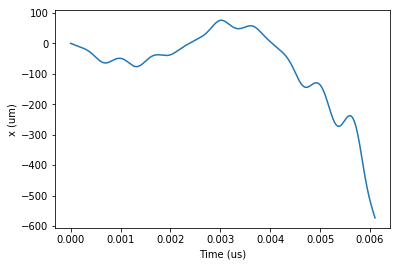

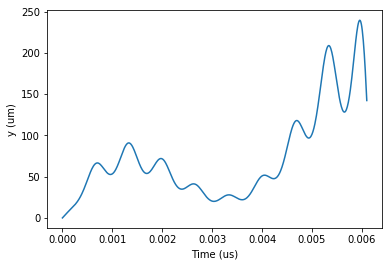

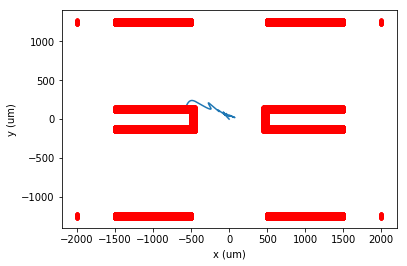

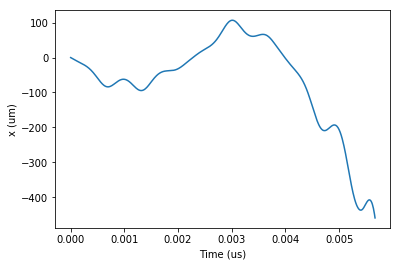

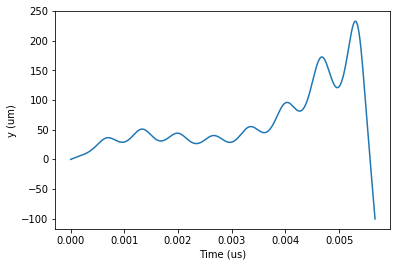

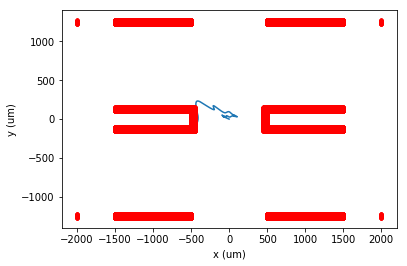

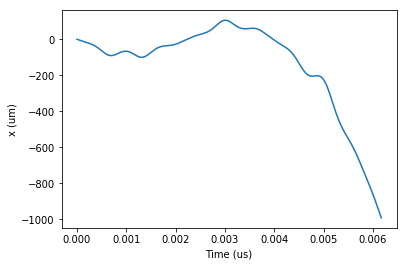

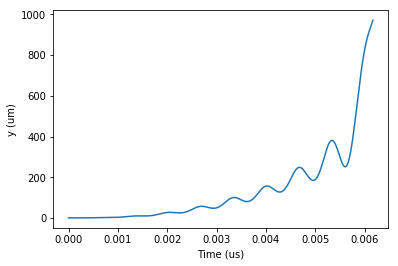

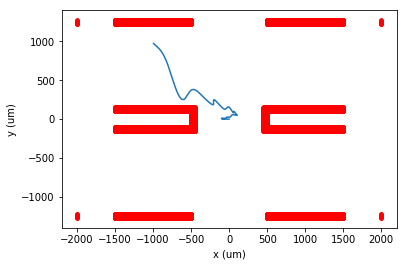

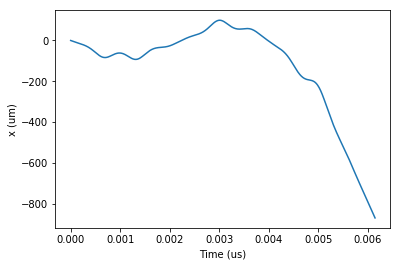

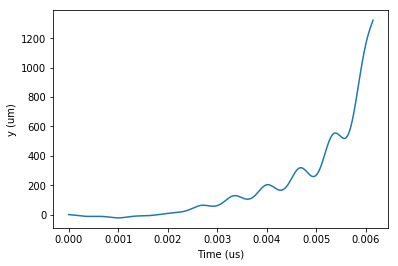

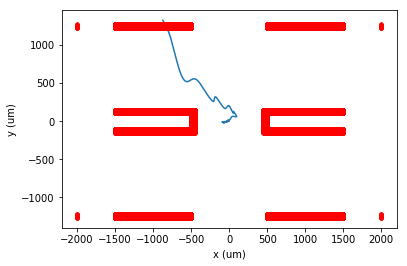

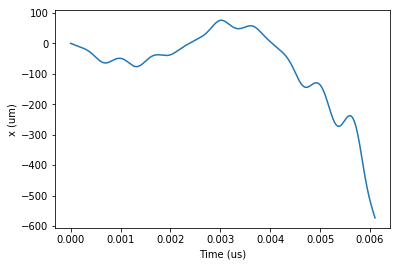

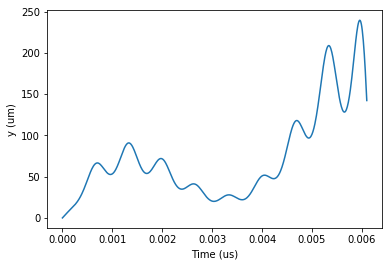

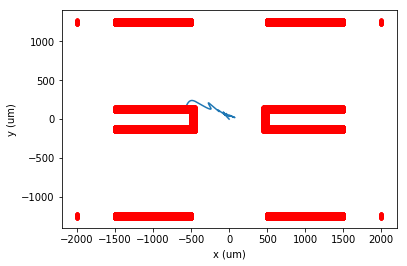

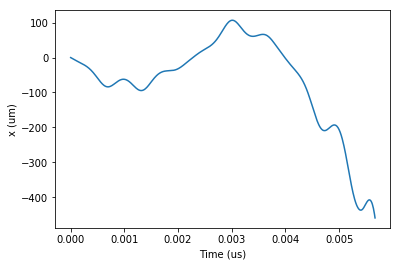

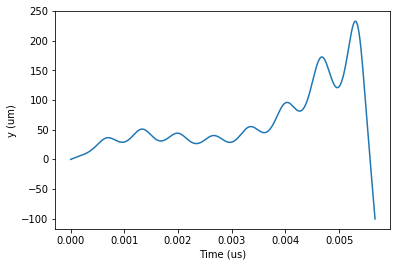

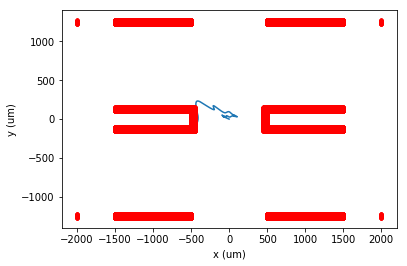

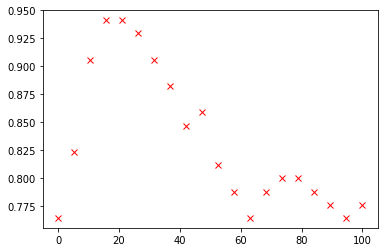

In [190]:
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

#initial condition
rho_s = np.linspace(0, 100.0e-6, 20)
N_phi = 5
N_theta = 17

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rho in rho_s
success_rate = dict() 
errors = dict()
count = 0
for T in [300.0]:
    v = np.sqrt(kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rho in rho_s:
        result = []
        for phi in np.linspace(0, np.pi/2, N_phi):
            for theta in np.linspace(0, np.pi*2, N_theta):
                if extracted(rho, phi, v, theta, dt, t_max):
                    result.append(1)
                else:
                    result.append(0)
                    count += 1
                    if count < 7:
                        plot_traj(rho, phi, T, theta, dt, t_max)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_phi*N_theta))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rho_s*1.0e6, success_rate[T], 'rx')
    

Text(0.5,1,'Room Temperature, 20ns ramping time')

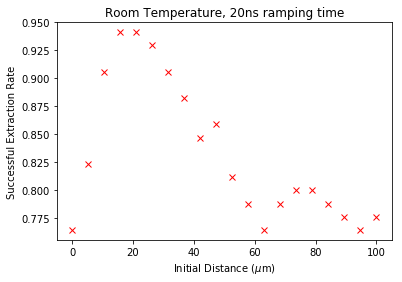

In [194]:
plt.plot(rho_s*1.0e6, success_rate[T], 'rx')
plt.xlabel("Initial Distance ($\mu$m)")
plt.ylabel("Successful Extraction Rate")
plt.title("Room Temperature, 20ns ramping time")

In [199]:
def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0] 
    if time < 100.0e-9:
        g1 = trap_RF.acceleration(x, y, time) + (1 - time/100.0e-9) * trap_DC0.acceleration(x, y, time) +\
        time/100.0e-9 * trap_DC1.acceleration(x, y ,time)
    else:
        g1 = trap_RF.acceleration(x, y, time) + trap_DC1.acceleration(x, y, time)
    return np.array([g0, g1])

Simulating T =  300.0 kelvin
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.016 us
time: 103997.92947292328
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.012 us
time: 104006.663138628
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.009 us
time: 104024.670940876
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.018 us
time: 104041.79466795921
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.014 us
time: 104051.6679327488
out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.013 us
time: 104061.14725780487
The result for T =  300.0 kelvin:


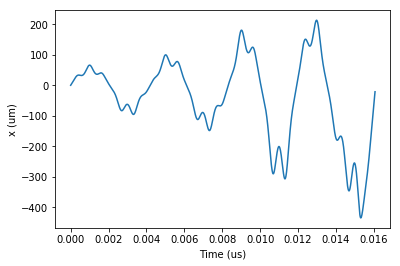

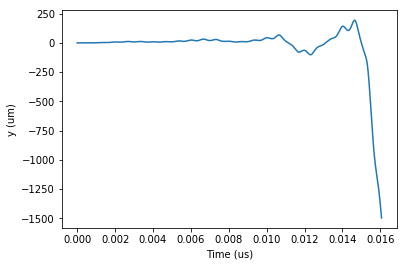

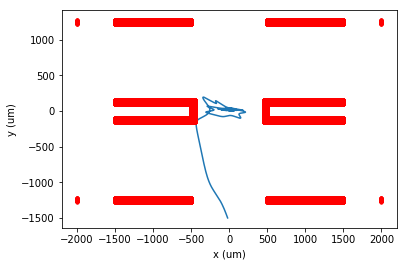

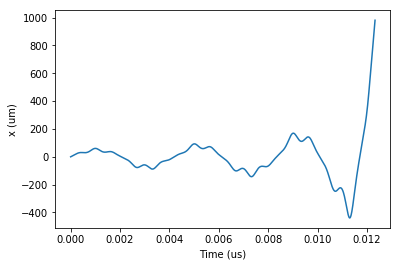

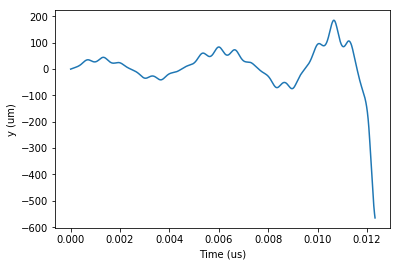

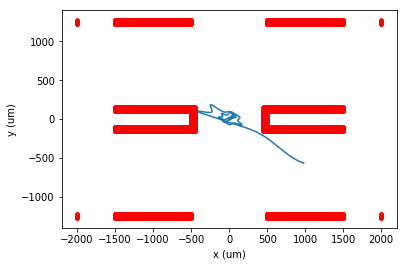

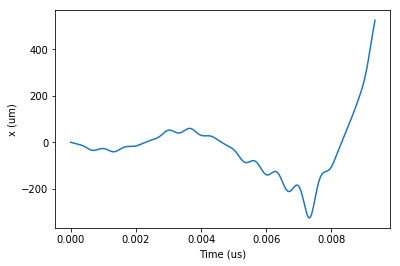

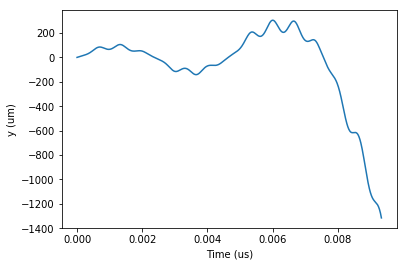

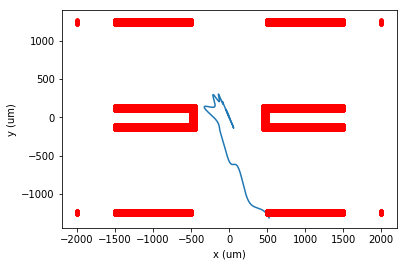

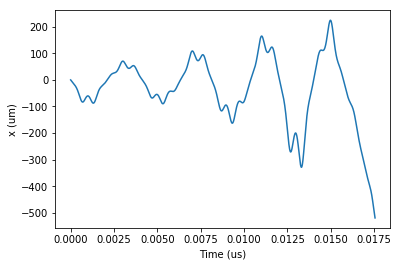

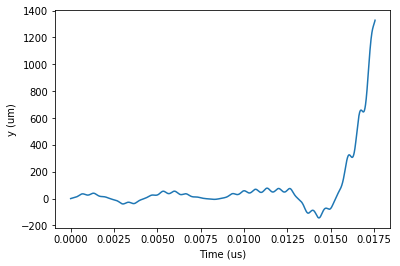

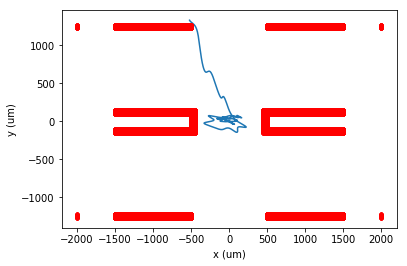

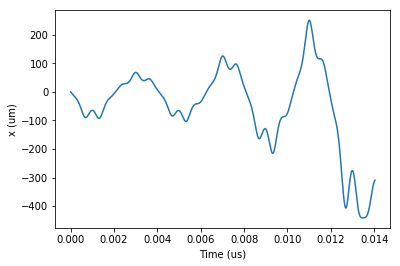

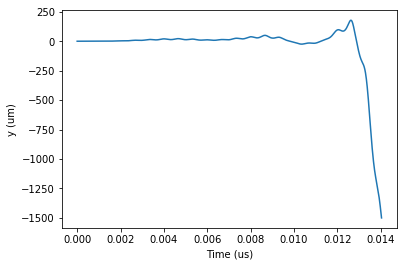

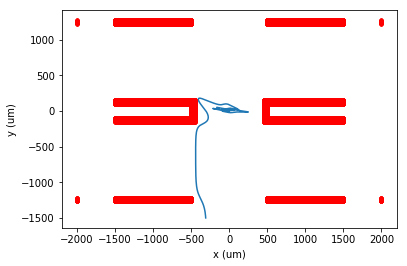

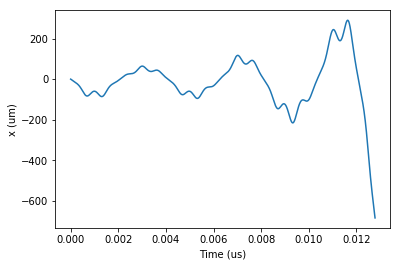

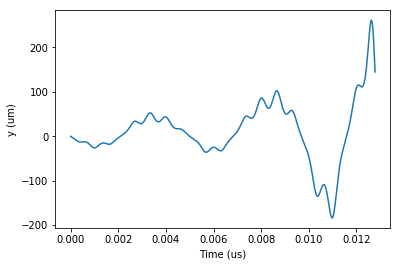

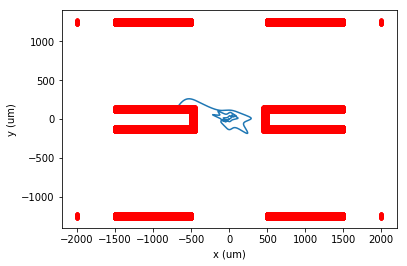

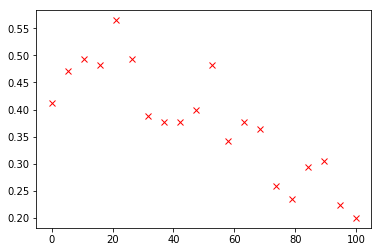

In [200]:
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

#initial condition
rho_s = np.linspace(0, 100.0e-6, 20)
N_phi = 5
N_theta = 17

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rho in rho_s
success_rate = dict() 
errors = dict()
count = 0
for T in [300.0]:
    v = np.sqrt(kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rho in rho_s:
        result = []
        for phi in np.linspace(0, np.pi/2, N_phi):
            for theta in np.linspace(0, np.pi*2, N_theta):
                if extracted(rho, phi, v, theta, dt, t_max):
                    result.append(1)
                else:
                    result.append(0)
                    count += 1
                    if count < 7:
                        plot_traj(rho, phi, T, theta, dt, t_max)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_phi*N_theta))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rho_s*1.0e6, success_rate[T], 'rx')